# VAE

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt

#Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data as data_lib

#Utilities
import os

## Download and Parse Data

In [0]:
%%capture
#Get data, small file so no if
if not os.path.isfile('all_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-ET9vXPKudU92XuWeR0wIL67byS2llq-' -O all_scaled0_1.csv
if not os.path.isfile('no_rfe_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-6Z60VHL0gk3pd8hKF7-btW_cM_DWTB6' -O no_rfe_scaled0_1.csv
if not os.path.isfile('models.7z'): 
    !wget 'https://drive.google.com/uc?export=download&id=1RPhLO70ip98tvbb4YImXPtEn1Sgz9svy' -O models.7z
    !7z x models.7z

In [0]:
# data_file = 'all_scaled0_1.csv'
# folder = 'models/all/'
data_file = 'no_rfe_scaled0_1.csv'
folder = 'models/no_rfe/'

In [48]:
data = pd.read_csv(data_file,index_col=0)
labels = data['label']
run = data['run']
chunkID = data['chunkID']
period = data['period']
data = data.drop(['label','chunkID','run','period'], axis = 1)

no_samples, no_features = data.shape

print(no_samples, no_features)
print(labels.value_counts())

data.head()

3429 133
0.0    3262
1.0     167
Name: label, dtype: int64


,bz,meanTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeCTPCncl,slopeCTPCnclErr,hasRawQA,rawSignalCounter,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZAchi2,slopedZAchi2,offsetdZCPos,offsetdZAchi2Pos,slopedZAchi2Pos,offsetdZCchi2Pos,slopedZCchi2Pos,slopedZANeg,offsetdZCNeg,slopedZCNeg,offsetdZAchi2Neg,slopedZAchi2Neg,offsetdZCchi2Neg,slopedZCchi2Neg,offsetdRC,offsetdRAchi2,slopedRAchi2,offsetdRCchi2,slopedRCchi2,dcarAP0,dcarCP0,...,dcar_negA_chi2,dcar_negA_0_Err,dcar_negA_1_Err,dcar_negA_2_Err,dcaz_negA_0,dcaz_negA_1,dcaz_negA_0_Err,dcaz_negA_1_Err,dcaz_negA_2_Err,dcaz_negC_chi2,dcaz_negC_0_Err,dcaz_negC_1_Err,dcaz_negC_2_Err,dcar_negC_chi2,dcar_negC_0_Err,dcar_negC_1_Err,dcar_negC_2_Err,iroc_A_side,oroc_A_side,iroc_C_side,oroc_C_side,tpcItsMatchA,tpcItsMatchC,phiPullHighPt,ptPull,ptPullHighPt,yPullHighPt,zPull,zPullHighPt,lambdaPull,meanPTRelativeA,medianPTRelativeA,rmsPTRelativeA,medianPTRelativeC,meanHVandPTGainCorrIROC,medianHVandPTGainCorrIROC,meanHVandPTGainCorrOROC,medianHVandPTGainCorrOROC,meanVDriftCorr,rmsVDriftCorr
0,0.0,0.650378,0.586648,0.299807,0.567304,0.506033,0.029799,0.506033,0.661859,0.130696,0.432987,0.432987,1.0,0.630747,0.505639,0.456515,0.479150,0.029047,0.025431,0.066360,0.066360,0.422997,0.018955,0.018955,0.103951,0.103951,0.347511,0.486962,0.366647,0.135214,0.135214,0.154272,0.154272,0.104897,0.041065,0.041065,0.165264,0.165264,0.023750,0.012700,...,0.040081,0.089056,0.082068,0.091172,0.387952,0.529658,0.075152,0.073086,0.076870,0.049049,0.064750,0.062988,0.066403,0.096599,0.092639,0.089595,0.096029,1.0,1.0,1.0,1.0,0.532074,0.586826,0.558088,0.489128,0.478282,0.397318,0.303648,0.494765,0.564013,0.644374,0.643025,0.030060,0.644593,0.644385,0.643058,0.731516,0.730402,0.062052,0.033067
1,0.0,0.652363,0.579001,0.299619,0.553643,0.490807,0.028887,0.490807,0.662852,0.129801,0.431335,0.431335,1.0,0.630747,0.471739,0.656468,0.622429,0.028192,0.024807,0.098105,0.098105,0.626295,0.078152,0.078152,0.195836,0.195836,0.318030,0.662324,0.531044,0.126243,0.126243,0.205944,0.205944,0.184002,0.120756,0.120756,0.277622,0.277622,0.023131,0.013681,...,0.029575,0.088029,0.080961,0.090309,0.368447,0.537606,0.074312,0.072295,0.075983,0.053690,0.062965,0.061329,0.064488,0.080482,0.090666,0.087815,0.093847,1.0,1.0,1.0,1.0,0.529813,0.583827,0.618659,0.506106,0.508984,0.428699,0.344592,0.458420,0.559882,0.645829,0.644559,0.044541,0.646086,0.645843,0.644604,0.732617,0.731569,0.061865,0.008953
2,0.0,0.656779,0.582115,0.302841,0.576802,0.486826,0.028507,0.486826,0.664891,0.128520,0.414198,0.414198,1.0,0.630747,0.424595,0.774050,0.716557,0.027634,0.024176,0.102944,0.102944,0.748653,0.144460,0.144460,0.224404,0.224404,0.301996,0.760046,0.627993,0.067836,0.067836,0.248870,0.248870,0.229955,0.088526,0.088526,0.349164,0.349164,0.022454,0.013235,...,0.040652,0.088169,0.080976,0.090568,0.377793,0.560263,0.073681,0.071540,0.075483,0.070414,0.062983,0.061441,0.064412,0.067023,0.090231,0.087507,0.093285,1.0,1.0,1.0,1.0,0.534614,0.584458,0.572836,0.508496,0.493338,0.420849,0.341413,0.461882,0.561373,0.645117,0.644090,0.046651,0.645604,0.645142,0.644119,0.732088,0.731203,0.061668,0.027615
3,0.0,0.650338,0.590880,0.307098,0.573718,0.465535,0.029239,0.465535,0.657125,0.127972,0.413237,0.413237,1.0,0.630747,0.453121,0.865839,0.786867,0.029305,0.025690,0.074307,0.074307,0.849890,0.084640,0.084640,0.224069,0.224069,0.307199,0.833085,0.699755,0.059567,0.059567,0.296804,0.296804,0.268384,0.103972,0.103972,0.427887,0.427887,0.023129,0.016565,...,0.024053,0.088482,0.081358,0.090786,0.376294,0.584689,0.074933,0.072717,0.076810,0.095369,0.064623,0.062784,0.066359,0.065335,0.091349,0.088426,0.094600,1.0,1.0,1.0,1.0,0.520301,0.572863,0.602295,0.511802,0.537189,0.439337,0.365844,0.496001,0.529956,0.639891,0.637870,0.174869,0.639382,0.639929,0.637938,0.728152,0.726535,0.061461,0.007084
4,0.0,0.654262,0.591539,0.319091,0.584242,0.494138,0.028849,0.494138,0.663947,0.132655,

In [49]:
#Parameters
params = {'batch_size': 128,
          'num_workers': 8}

X_train_t = torch.FloatTensor(data.to_numpy())
y_train_t = torch.FloatTensor(labels.to_numpy()) #in fact redundant
train_dataset = data_lib.TensorDataset(X_train_t,y_train_t)
train_gen = data_lib.DataLoader(train_dataset, **params)

#Check if all fine
next(iter(train_gen))

[tensor([[0.0000, 0.6504, 0.5866,  ..., 0.7304, 0.0621, 0.0331],
         [0.0000, 0.6524, 0.5790,  ..., 0.7316, 0.0619, 0.0090],
         [0.0000, 0.6568, 0.5821,  ..., 0.7312, 0.0617, 0.0276],
         ...,
         [0.0000, 0.6851, 0.5503,  ..., 0.7192, 0.1492, 0.0434],
         [0.0000, 0.6812, 0.5570,  ..., 0.7158, 0.1486, 0.0485],
         [0.0000, 0.6683, 0.5600,  ..., 0.7022, 0.1171, 0.2459]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.])]

##Define Model

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3_1 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.fc3_2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))

        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        # What is returned is mu and logvar, mean and var that will be used to cacl std
        return self.dropout(self.fc3_1(x)), self.dropout(self.fc3_2(x))

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class VAE(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std    

    def forward(self, X):
        mu, logvar = self.encoder(X)
        z = self.reparameterize(mu, logvar)

        return self.decoder(z), mu, logvar

In [0]:
#Define loss function
def loss_function(recon_x, x, mu, logvar):
    #Generation loss - compare generated to obtained
    gen_loss_func = nn.MSELoss(reduction='sum')
    GL = gen_loss_func(recon_x, x)  
    # KL divergence that measures how closely the latent variables match a unit gaussian.
    #Simplified version
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return GL + KLD  

In [53]:
# check if CUDA is available
gpu = torch.cuda.is_available()

if not gpu:
    print('CUDA is not available.  Training on CPU ...')

else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [54]:
#Instaciate model and set training parameters
dropout = 0.3
latent_ratio = [0.5, 0.3, 0.1] #Must be 3 elements


model = VAE(no_features, latent_ratio, dropout)
if gpu:
    model.cuda()
# Predefined loss function
criterion = loss_function
# Optimizer - Adam
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(model)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=133, out_features=66, bias=True)
    (fc2): Linear(in_features=66, out_features=40, bias=True)
    (fc3_1): Linear(in_features=40, out_features=13, bias=True)
    (fc3_2): Linear(in_features=40, out_features=13, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=13, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=66, bias=True)
    (fc3): Linear(in_features=66, out_features=133, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)


## Check model

In [55]:
# Load some variable for test (we dont care about labels)
features, labels = next(iter(train_gen))
if gpu:
    features = features.cuda()

#Check if size is correct, should be batch_size x no_features
print(features.shape)

# Show values after passing throught untrained network 
model.forward(features)[:1]

torch.Size([128, 133])


(tensor([[0.4802, 0.4758, 0.4956,  ..., 0.4877, 0.5079, 0.4405],
         [0.5080, 0.4463, 0.5131,  ..., 0.5078, 0.5341, 0.4637],
         [0.5190, 0.4284, 0.4807,  ..., 0.4340, 0.5211, 0.4029],
         ...,
         [0.5264, 0.4696, 0.5032,  ..., 0.4833, 0.5282, 0.4805],
         [0.5047, 0.4239, 0.4765,  ..., 0.4784, 0.5104, 0.4182],
         [0.5804, 0.4917, 0.4982,  ..., 0.4960, 0.5591, 0.3846]],
        device='cuda:0', grad_fn=<SigmoidBackward>),)

##Train Model

In [56]:
# number of epochs
n_epochs = 50

train_loss_min = np.Inf # to track change in validation loss
train_loss_hist = []

# Iterate on epochs 
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0

    # Set model to train mode (to include dropout)
    model.train()
    
    # iterate on data batches, discard labels
    for features, _ in train_gen:
        # move tensors to GPU if CUDA is available
        if gpu:
            features = features.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs throught the model
        output, mu, logvar = model.forward(features)
        # calculate the batch loss by compering to initial features
        loss = criterion(output, features, mu, logvar)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss , mulitply by batchsize, no idea why
        train_loss += loss.item() *features.size(0)
          
    # calculate average losses
    train_loss = train_loss/len(train_gen.sampler)
    train_loss_hist.append(train_loss)
    
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f}'.format(epoch, train_loss))
    
    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        print('Train loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(train_loss_min, train_loss))
        torch.save(model.state_dict(), 'vae.pt')
        train_loss_min = train_loss

Epoch: 1 	Training Loss: 2048.1963
Train loss decreased (inf --> 2048.1963).  Saving model ...
Epoch: 2 	Training Loss: 1984.1574
Train loss decreased (2048.1963 --> 1984.1574).  Saving model ...
Epoch: 3 	Training Loss: 1918.1497
Train loss decreased (1984.1574 --> 1918.1497).  Saving model ...
Epoch: 4 	Training Loss: 1842.4651
Train loss decreased (1918.1497 --> 1842.4651).  Saving model ...
Epoch: 5 	Training Loss: 1742.2431
Train loss decreased (1842.4651 --> 1742.2431).  Saving model ...
Epoch: 6 	Training Loss: 1626.0619
Train loss decreased (1742.2431 --> 1626.0619).  Saving model ...
Epoch: 7 	Training Loss: 1470.1851
Train loss decreased (1626.0619 --> 1470.1851).  Saving model ...
Epoch: 8 	Training Loss: 1305.2380
Train loss decreased (1470.1851 --> 1305.2380).  Saving model ...
Epoch: 9 	Training Loss: 1123.9389
Train loss decreased (1305.2380 --> 1123.9389).  Saving model ...
Epoch: 10 	Training Loss: 952.9313
Train loss decreased (1123.9389 --> 952.9313).  Saving model .

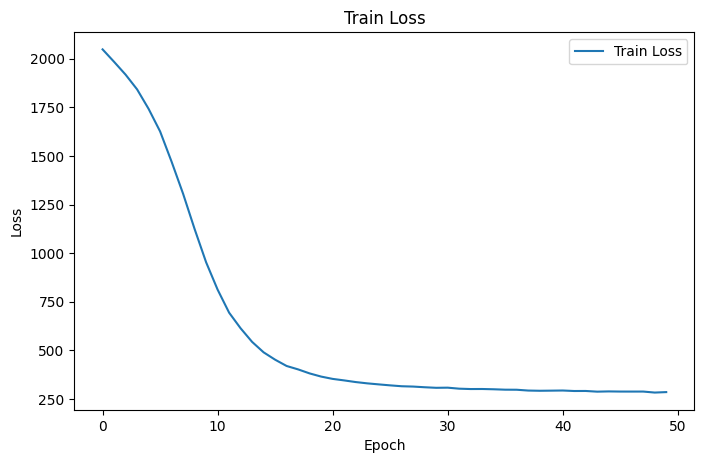

In [57]:
# Visualize training 
fig = plt.figure(figsize = (8,5), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss_hist)

ax.legend(['Train Loss'])

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss');